## 单层感知机SoftMax实现

  - 以Fashion-MNIST为例

In [ ]:
#pip install d2l

In [1]:
import torch
from IPython import display
from d2l import torch as d2l

#引入的Fashion-MNIST数据集， 并设置数据迭代器的批量大小为256。
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw
Processing...
Done!


### 输入
**我们的输出与类别一样多。 因为我们的数据集有10个类别，所以网络输出维度为10。 因此，权重将构成一个784x10的矩阵， 偏置将构成一个1x10的行向量。 与线性回归一样，我们将使用正态分布初始化我们的权重W，偏置初始化为0**

In [2]:
num_inputs = 784
num_outputs = 10

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

实现softmax由三个步骤组成：

1. 对每个项求幂（使用exp）；

2. 对每一行求和（小批量中每个样本是一行），得到每个样本的规范化常数；

3. 将每一行除以其规范化常数，确保结果的和为1

SoftMax函数定义：
$$SoftMax(X)_{ij}=\frac{exp(X_{ij})}{\sum_kexp(X_{ik})}$$

In [4]:
def softmax(X):
    """
    对于任何随机输入X，我们将每个元素变成一个非负数。 此外，依据概率原理，每行总和为1
    """
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition  # 这里应用了广播机制,如果运算符前后向量的shape不同则复制成相同的shape再进行运算

In [13]:
# 验证代码输出是否正确
X = torch.normal(0, 1, (2, 5))
print("输入:\n",X)
X_prob = softmax(X)
print("softmax输入结果:\n",X_prob) 
print("计算每行的总和:\n",X_prob.sum(1))

输入:
 tensor([[ 0.1022,  1.7311,  0.7546, -0.6504, -0.7544],
        [-0.5824,  0.9778,  0.3155, -1.6904, -0.8238]])
softmax输入结果:
 tensor([[0.1122, 0.5719, 0.2154, 0.0529, 0.0476],
        [0.1072, 0.5102, 0.2631, 0.0354, 0.0842]])
计算每行的总和:
 tensor([1.0000, 1.0000])


### 定义模型
实现softmax回归模型:

下面的代码定义了输入如何通过网络映射到输出  

注意: 
- 将数据传递到模型之前，我们使用reshape函数将每张原始图像展平为向量
- matual:把输入转化为tensor

In [14]:
def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

### 损失函数
定义交叉熵损失函数：交叉熵采用真实标签的预测概率的负对数似然
注意：不使用Python的for循环迭代预测（这往往是低效的）， 而是通过一个运算符选择所有元素

1. 定义数据样本y_hat，其中包含2个样本在3个类别(0,1,2)的预测概率， 以及它们对应的标签y。 
2. 有了y，我们知道在第一个样本中，第一类是正确的预测； 而在第二个样本中，第三类是正确的预测。 
3. 使用y作为y_hat中概率的索引， 我们选择第一个样本中第一个类的概率和第二个样本中第三个类的概率

In [15]:
#步骤代码
y = torch.tensor([0, 2]) #标签
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]]) #数据
y_hat[[0, 1], y] #预测结果与标签对比计算概率

tensor([0.1000, 0.5000])

交叉熵函数的数学推导及定义：

推导步骤：
1. 向量Y视作对给定任意输入X的每个类的条件概率
2. $y^{(i)}$为标签向量，$x^{(i)}$为特征向量
3. 将估计值与实际值进行对比，即$P(Y|X)$
4. 极大似然估计，最大化$P(Y|X)$
5. 得出最终损失函数

\begin{gather}
P(Y|X) = \prod_{i=1}^{n}P(y^{(i)}|x^{(i)})  \\
-logp(Y|X) = \sum_{i=1}^{n}-logP(y^{(i)}|x^{(i)}) 
=\sum_{i=1}^{n}loss(y^{i},\hat{y}^{(i)})
\end{gather}

所以损失函数可改写为：$$loss(y,\hat{y})= -\sum_{j=1}^{n}y_jlog\hat{y}_j$$


In [16]:
def cross_entropy(y_hat, y):
    """
    交叉熵函数的定义
    """
    return - torch.log(y_hat[range(len(y_hat)), y])

cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

### 分类精度
给定预测概率分布y_hat，当我们必须输出硬预测（hard prediction）时， 我们通常选择预测概率最高的类

**关于精度的几个注意点**：
1. 当预测与标签分类y一致时，即是正确的。
2. 分类精度即正确预测数量与总预测数量之比。 
3. 虽然直接优化精度可能很困难（因为精度的计算不可导）， 但精度通常是我们最关心的性能衡量标准。

**分类精度的计算步骤**：
1. 如果y_hat是矩阵，那么假定第二个维度存储每个类的预测分数。 我们使用argmax获得每行中最大元素的索引来获得预测类别。 
2. 我们将预测类别与真实y元素进行比较。 由于等式运算符“==”对数据类型很敏感， 因此我们将y_hat的数据类型转换为与y的数据类型一致。 
3. 结果是一个包含0（错）和1（对）的张量。
4. 最后，我们求和会得到正确预测的数量

In [17]:
def accuracy(y_hat, y):  #@save
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [35]:
print("分类器精度：%f" %(accuracy(y_hat, y) / len(y)))

分类器精度：0.500000


In [25]:
print("3个类别的预测概率:\n",y_hat)
print("标签:\n",y)

3个类别的预测概率:
 tensor([[0.1000, 0.3000, 0.6000],
        [0.3000, 0.2000, 0.5000]])
标签:
 tensor([0, 2])


**结果分析：**
1. 第一个样本的预测类别是2（该行的最大元素为0.6，索引为2），这与实际标签0不一致。 
2. 第二个样本的预测类别是2（该行的最大元素为0.5，索引为2），这与实际标签2一致。 
3. 因此，这两个样本的分类精度率为0.5

In [37]:
def evaluate_accuracy(net, data_iter):  
    """
    function:计算在指定数据集上模型的精度
    net:任意模型
    data_iter:数据迭代器可访问的数据集
    """
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
        
    # 在Accumulator实例中创建了2个变量， 分别用于存储正确预测的数量和预测的总数量    
    metric = Accumulator(2) 
    
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [38]:
class Accumulator:  
    """在n个变量上累加，"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [53]:
# Accumulator类用法及输出结果测试
metric = Accumulator(2)
for X, y in train_iter:
    metric.add(accuracy(net(X), y), y.numel())
    break
    
print("正确预测数量：%d\n预测的总数量：%d"%(metric[0],metric[1]))

正确预测数量：45
预测的总数量：256


我们使用随机权重初始化net模型， 因此该模型的精度应接近于随机猜测(fashion_mnist有10个类别)  $ E(Y)=0.1$

In [54]:
evaluate_accuracy(net, test_iter)

0.135

In [55]:
def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """训练模型一个迭代周期（定义见第3章）"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

In [56]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """训练模型"""
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
    train_loss, train_acc = train_metrics
    
    #模型精度过高过低，抛出异常
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [57]:
lr = 0.1
# 优化器采用随机梯度下降来迭代更新w和b
def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

In [59]:
num_epochs = 1
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

AssertionError: 0.7213580004374186

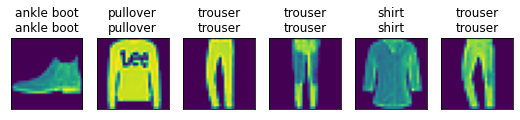

In [60]:
def predict_ch3(net, test_iter, n=6):  #@save
    """预测标签"""
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)

## 多层感知机&前馈神经网络

**与单层感知机的对比**

* 增加了多个隐藏层

* sigmoid函数在梯度下降优化时容易发生梯度消失和梯度爆炸，阻碍参数的更新，所以提出了其他的激活函数来替换sigmoid

In [61]:
# 实现Relu激活函数
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

In [63]:
""" 定义多层感知机的网络结构""" 
import torch.nn as nn
#输入层、输出层、隐层的大小
num_inputs, num_outputs, num_hiddens = 784, 10, 256
#隐层神经元权重和偏执的定义
W1 = nn.Parameter(torch.randn(
    num_inputs, num_hiddens, requires_grad=True) * 0.01)
b1 = nn.Parameter(torch.zeros(num_hiddens, requires_grad=True))

W2 = nn.Parameter(torch.randn(
    num_hiddens, num_outputs, requires_grad=True) * 0.01)
b2 = nn.Parameter(torch.zeros(num_outputs, requires_grad=True))

params = [W1, b1, W2, b2]

In [64]:
"""
这里我们忽略输入的空间结构(输入的矩阵的空间结构也是可以作为特征的)，
所以我们使用reshape将每个二维图像转换为一个长度为num_inputs的向量
"""
def net(X):
    X = X.reshape((-1, num_inputs))
    H = relu(X@W1 + b1)  # 这里" @ "代表矩阵乘法
    return (H@W2 + b2)

In [66]:
"""
这里采用我们自己简单定义的交叉熵函数(必然存在缺陷，也可以考虑直接调包，不过建议手动试试) 

自己定义的损失函数哪里会存在问题呢？
1. 网络参数初始化不得当，比如过大或过小，又或者输入有较大的噪声，都会造成数值下溢，因为计算多个对数运算，下溢导致无限接近0
2. 预测概率向量如果也接近0，损失函数也会下溢 
"""
loss = cross_entropy 

In [ ]:
num_epochs, lr = 10, 0.1
updater = torch.optim.SGD(params, lr=lr)

train_ch3(net, train_iter, test_iter, loss, num_epochs, updater)
predict_ch3(net, test_iter)

# 过拟合与欠拟合

当我们比较训练和验证误差时，我们要注意两种常见的情况。 首先，我们要注意这样的情况：训练误差和验证误差都很严重， 但它们之间仅有一点差距。 **如果模型不能降低训练误差，这可能意味着模型过于简单（即表达能力不足）， 无法捕获试图学习的模式**。 此外，由于我们的训练和验证误差之间的泛化误差很小， 我们有理由相信可以用一个更复杂的模型降低训练误差。 这种现象被称为欠拟合（underfitting）
另一方面，**当我们的训练误差明显低于验证误差时要小心， 这表明严重的过拟合（overfitting）**。 注意，过拟合并不总是一件坏事。 特别是在深度学习领域，众所周知， 最好的预测模型在训练数据上的表现往往比在保留（验证）数据上好得多。 最终，我们通常更关心验证误差，而不是训练误差和验证误差之间的差距。

是否过拟合或欠拟合可能取决于模型复杂性和可用训练数据集的大小，我们分别探究一下这两个因素：

### 模型复杂性
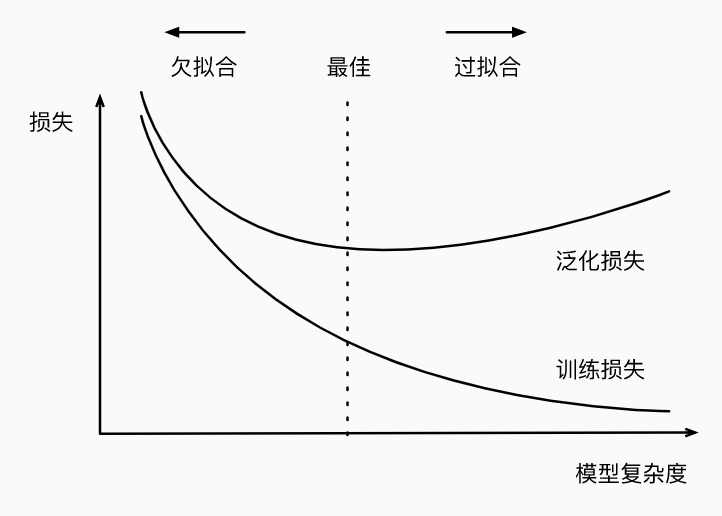

在固定数据集大小的情况下，我们通过这样一张图来描述模型复杂度与损失函数的关系：
1. 在模型复杂度并不高的情况下，增加模型复杂度可以降低损失函数，即训练误差降低
2. 模型复杂度很高的情况下，会导师损失函数上升，即训练误差升高


### 数据集大小

 训练数据集中的样本越少，我们就越有可能（且更严重地）过拟合。 随着训练数据量的增加，泛化误差通常会减小。 此外，一般来说，更多的数据不会有什么坏处。 对于固定的任务和数据分布，模型复杂性和数据集大小之间通常存在关系。 给出更多的数据，我们可能会尝试拟合一个更复杂的模型。 能够拟合更复杂的模型可能是有益的。 如果没有足够的数据，简单的模型可能更有用。 对于许多任务，深度学习只有在有数千个训练样本时才优于线性模型
 
 
- 而针对深度学习而言，训练需要学习的参数量巨大，大多数情况是模型过拟合 

## 解决过拟合
以下讨论两种深度学习中常用的缓解过拟合的方法
1. 权重衰退
2. 暂退法


### 权重衰退
在训练参数化机器学习模型时， 权重衰减（weight decay）是最广泛使用的正则化的技术之一， 它通常也被称为正则化。 这项技术通过函数与零的距离来衡量函数的复杂度， 因为在所有函数中，函数$f$（所有输入都得到值）$f=0$ 在某种意义上是最简单的.

一种简单的方法是通过线性函数$f(x)=w^{T}x$  中的权重向量的某个范数来度量其复杂性， 例如$\rVert w \rVert^2$。 要保证权重向量比较小， 最常用方法是将其范数作为惩罚项加到最小化损失的问题中。 将原来的训练目标最小化训练标签上的预测损失， 调整为最小化预测损失和惩罚项之和。 现在，如果我们的权重向量增长的太大， 我们的学习算法可能会更集中于最小化权重范数$\rVert w \rVert^2$。 假设我们的损失函数由线性回归给出:
$$L(w,b)= \frac{1}{n}\sum\frac{1}{2}(w^{T}+b-y^{(i)})^2$$

$x^{(i)}$是样本$i$的特征， $y^{(i)}$是样本$i$的标签， $(w,b)$是权重和偏置参数。 为了惩罚权重向量的大小， 我们必须以某种方式在损失函数中添加$\rVert w \rVert^2$但是模型应该如何平衡这个新的额外惩罚的损失？ 实际上，我们通过正则化常数$\lambda$来描述这种权衡， 这是一个非负超参数，我们使用验证数据拟合：
$$L(w,b)+\frac{\lambda}{2}\rVert w \rVert^2$$

对于$ \lambda $，我们恢复了原来的损失函数。 对于$ \lambda >0$，我们限制$\rVert w \rVert$的大小。 这里我们仍然除以$2$：当我们取一个二次函数的导数时， $2$和$1/2$会抵消，以确保更新表达式看起来既漂亮又简单。 你可能会想知道为什么我们使用平方范数而不是标准范数（即欧几里得距离）？ 我们这样做是为了便于计算。 通过平方$L_2$范数，我们去掉平方根，留下权重向量每个分量的平方和。 这使得惩罚的导数很容易计算：导数的和等于和的导数

此外，你可能会问为什么我们首先使用$L_2$范数，而不是$L_1$范数。 事实上，这个选择在整个统计领域中都是有效的和受欢迎的。 $L_2$正则化线性模型构成经典的岭回归（ridge regression）算法， $L_1$正则化线性回归是统计学中类似的基本模型， 通常被称为套索回归（lasso regression）。 使用$L_2$范数的一个原因是它对权重向量的大分量施加了巨大的惩罚。 这使得我们的学习算法偏向于在大量特征上均匀分布权重的模型。 在实践中，这可能使它们对单个变量中的观测误差更为稳定。 相比之下，$L_1$惩罚会导致模型将权重集中在一小部分特征上， 而将其他权重清除为零.

$L_2$正则化回归的小批量随机梯度下降更新公式如下：
$$w \leftarrow (1-\eta\lambda)w - \frac{\eta}{|N|}\Sigma_{i\in N} x^{(i)}(w^T x^{(i)}+b-y^{(i)})$$

我们根据估计值与观测值之间的差异来更新$w$。 然而，我们同时也在试图将$w$的大小缩小到零。 这就是为什么这种方法有时被称为权重衰减。 我们仅考虑惩罚项，优化算法在训练的每一步衰减权重。 与特征选择相比，权重衰减为我们提供了一种连续的机制来调整函数的复杂度。 较小的$w$值对应较少约束的$\lambda$， 而较大的$w$值对的约束更大。

是否对相应的偏置$b^2$进行惩罚在不同的实践中会有所不同， 在神经网络的不同层中也会有所不同。 通常，网络输出层的偏置项不会被正则化。


### 暂退法

重新考虑一下线性回归模型：
当面对更多的特征而样本不足时，线性模型往往会过拟合。 相反，当给出更多样本而不是特征，通常线性模型不会过拟合。 不幸的是，线性模型泛化的可靠性是有代价的。 简单地说，线性模型没有考虑到特征之间的交互作用。 对于每个特征，线性模型必须指定正的或负的权重，而忽略其他特征

泛化性和灵活性之间的这种基本权衡被描述为偏差-方差权衡（bias-variance tradeoff）。 线性模型有很高的偏差：它们只能表示一小类函数。 然而，这些模型的方差很低：它们在不同的随机数据样本上可以得出相似的结果

深度神经网络位于偏差-方差谱的另一端。 与线性模型不同，神经网络并不局限于单独查看每个特征，而是学习特征之间的交互。

在探究泛化性之前，我们先来定义一下什么是一个“好”的预测模型？ 我们期待“好”的预测模型能在未知的数据上有很好的表现： 经典泛化理论认为，为了缩小训练和测试性能之间的差距，应该以简单的模型为目标。 简单性以较小维度的形式展现，在讨论线性模型的时探讨了这一点。此外，在权重衰减（$L_2$正则化）时看到的那样， 参数的范数也代表了一种有用的简单性度量。

简单性的另一个角度是平滑性，即函数不应该对其输入的微小变化敏感。 例如，当我们对图像进行分类时，我们预计向像素添加一些随机噪声应该是基本无影响的。 

1995年，克里斯托弗·毕晓普证明了 具有输入噪声的训练等价于Tikhonov正则化 [Bishop, 1995]。 这项工作用数学证实了“要求函数光滑”和“要求函数对输入的随机噪声具有适应性”之间的联系。

2014年，斯里瓦斯塔瓦等人 [Srivastava et al., 2014] 就如何将毕晓普的想法应用于网络的内部层提出了一个想法： 在训练过程中，他们建议在计算后续层之前向网络的每一层注入噪声。 因为当训练一个有多层的深层网络时，注入噪声只会在输入-输出映射上增强平滑性。

斯里瓦斯塔瓦等人这个想法被称为暂退法（dropout）。 暂退法在前向传播过程中，计算每一内部层的同时注入噪声，这已经成为训练神经网络的常用技术。 这种方法之所以被称为暂退法，因为我们从表面上看是在训练过程中丢弃（drop out）一些神经元。 在整个训练过程的每一次迭代中，标准暂退法包括在计算下一层之前将当前层中的一些节点置零。
那么关键的挑战就是如何注入这种噪声。 一种想法是以一种无偏向（unbiased）的方式注入噪声。 这样在固定住其他层时，每一层的期望值等于没有噪音时的值。

在标准暂退法正则化中，通过按保留（未丢弃）的节点的分数进行规范化来消除每一层的偏差。 换言之，每个中间活性值以暂退概率由随机变量替换，如下所示：

$$ 
概率为p: h'=0 \\
其他情况: h'=\frac{0}{1-p}
$$
 
根据此模型的设计，其期望值保持不变，即$E\left[ h' \right] = h$。

当我们将暂退法应用到隐藏层，以$p$的概率将隐藏单元置为零时， 结果可以看作是一个只包含原始神经元子集的网络。 比如在 图4.6.1中，删除了$h_2$和$h_5$， 因此输出的计算不再依赖于$h_2$或$h_5$，并且它们各自的梯度在执行反向传播时也会消失。 这样，输出层的计算不能过度依赖于$h_1,...,h_5$的任何一个元素

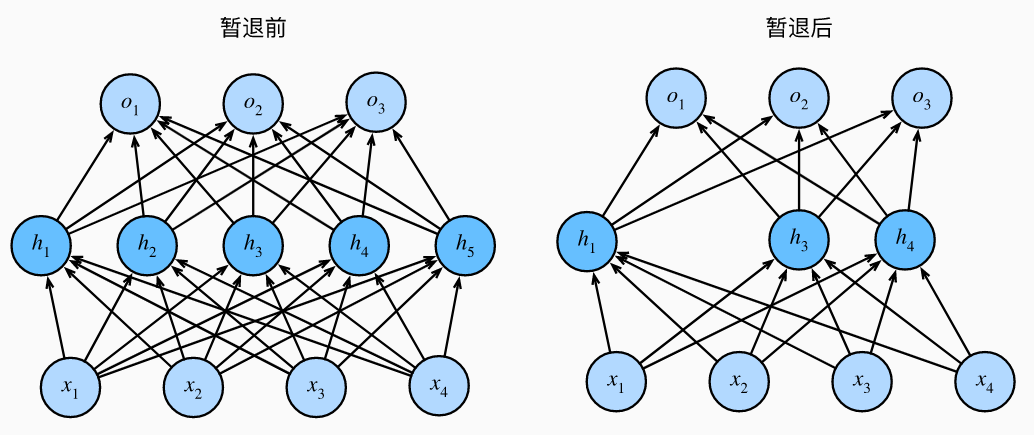

## 卷积神经网络

卷积神经网络是包含卷积层的一类特殊的神经网络。 在深度学习中，图像处理的区域检测对象被称为卷积核（convolution kernel）或者滤波器（filter），亦或简单地称之为该卷积层的权重，通常该权重是可学习的参数。 当图像处理的局部区域很小时，卷积神经网络与多层感知机的训练差异可能是巨大的：以前，多层感知机可能需要数十亿个参数来表示网络中的一层，而现在卷积神经网络通常只需要几百个参数，而且不需要改变输入或隐藏表示的维数。 参数大幅减少的代价是，我们的特征现在是平移不变的，并且当确定每个隐藏活性值时，每一层只包含局部的信息。 以上所有的权重学习都将依赖于归纳偏置。当这种偏置与现实相符时，我们就能得到样本有效的模型，并且这些模型能很好地泛化到未知数据中。 但如果这偏置与现实不符时，比如当图像不满足平移不变时，我们的模型可能难以拟合我们的训练数据

卷积神经网络具有的特性：

1. 平移不变性（translation invariance）：不管检测对象出现在图像中的哪个位置，神经网络的前面几层应该对相同的图像区域具有相似的反应，即为“平移不变性”。图像的平移不变性使我们以相同的方式处理局部图像，而不在乎它的位置。

2. 局部性（locality）：神经网络的前面几层应该只探索输入图像中的局部区域，而不过度在意图像中相隔较远区域的关系，这就是“局部性”原则。最终，可以聚合这些局部特征，以在整个图像级别进行预测。局部性意味着计算相应的隐藏表示只需一小部分局部图像像素。



- 在图像处理中，卷积层通常比全连接层需要更少的参数，但依旧获得高效用的模型



卷积的数学定义：

设两个函数$f,g:R^d \to R$ 之间的卷积被定义为：
$$(f*g)(x)= \int f(z)g(x-z),dz$$

也就是说，卷积是当把一个函数“翻转”并移位$x$时，测量$f$和$g$之间的重叠



严格来说，卷积层是个错误的叫法，因为它所表达的运算其实是互相关运算（cross-correlation），而不是卷积运算。在卷积层中，输入张量和核张量通过互相关运算产生输出张量

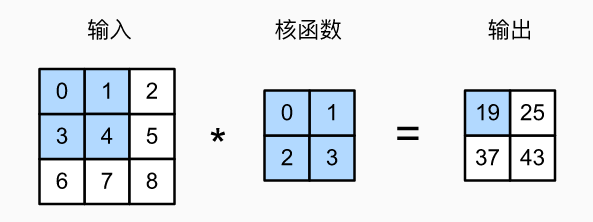

$$ 0x0 +1x1 +3x2+4x3=19$$

注意，输出大小略小于输入大小。这是因为卷积核的宽度和高度大于1， 而卷积核只与图像中每个大小完全适合的位置进行互相关运算。 所以，输出大小$n_h$x$n_w$等于输入大小减去卷积核$k_h$x$k_w$大小

输入大小：$(n_h-k_h+1)$x$(n_w-k_w+1)$

这是因为我们需要足够的空间在图像上“移动”卷积核。稍后，我们将看到如何通过在图像边界周围填充零来保证有足够的空间移动卷积核，从而保持输出大小不变。

然而这种方法有一些问题：

1. 我们忽略了图像一般包含三个通道/三种原色（红色、绿色和蓝色）。 实际上，图像不是二维张量，而是一个由高度、宽度和颜色组成的三维张量，比如包含个像素。 前两个轴与像素的空间位置有关，而第三个轴可以看作是每个像素的多维表示,所以应该增加第三个维度表示

2. 此外，由于输入图像是三维的，我们的隐藏表示$H$也最好采用三维张量。 换句话说，对于每一个空间位置，我们想要采用一组而不是一个隐藏表示。这样一组隐藏表示可以想象成一些互相堆叠的二维网格。 因此，我们可以把隐藏表示想象为一系列具有二维张量的通道（channel）。 这些通道有时也被称为特征映射（feature maps），因为每个通道都向后续层提供一组空间化的学习特征。 直观上你可以想象在靠近输入的底层，一些通道专门识别边缘，而一些通道专门识别纹理。

In [1]:
import torch
from torch import nn

def corr2d(X, K):  #@save
    """计算二维互相关运算"""
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()
    return Y

In [2]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

### 添加卷积层
卷积层对输入和卷积核权重进行互相关运算，并在添加标量偏置之后产生输出。 所以，卷积层中的两个被训练的参数是卷积核权重和标量偏置。 就像我们之前随机初始化全连接层一样，在训练基于卷积层的模型时，我们也随机初始化卷积核权重。


In [3]:
class Conv2D(nn.Module):
    """
    基于上面定义的corr2d函数实现二维卷积层。
    在__init__构造函数中，将weight和bias声明为两个模型参数。
    forward前向传播函数调用corr2d函数并添加偏置。
    """
    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return corr2d(x, self.weight) + self.bias

高度和宽度分别为$h$和$2$的卷积核可以被称为$hxw$卷积或$hxw$卷积核。 我们也将带有$hxw$卷积核的卷积层称为$hxw$卷积层。

### 边缘检测小例子

In [7]:
X = torch.ones((6, 8))
X[:, 2:6] = 0
print(X)

#构造一个高度为1、宽度为2的卷积核K。当进行互相关运算时，如果水平相邻的两元素相同，则输出为零，否则输出为非零。
K = torch.tensor([[1.0, -1.0]])

#对参数X（输入）和K（卷积核）执行互相关运算。 
#输出Y中的1代表从白色到黑色的边缘，-1代表从黑色到白色的边缘，其他情况的输出为"""
Y = corr2d(X, K)
Y

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])


tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

In [8]:
"""学习卷积层 """

# 构造一个二维卷积层，它具有1个输出通道和形状为（1，2）的卷积核
conv2d = nn.Conv2d(1,1, kernel_size=(1, 2), bias=False)

# 这个二维卷积层使用四维输入和输出格式（批量大小、通道、高度、宽度），
# 其中批量大小和通道数都为1
X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))
lr = 3e-2  # 学习率

for i in range(10):
    Y_hat = conv2d(X)
    l = (Y_hat - Y) ** 2
    conv2d.zero_grad()
    l.sum().backward()
    # 迭代卷积核
    conv2d.weight.data[:] -= lr * conv2d.weight.grad
    
    if (i + 1) % 2 == 0:
        print(f'epoch {i+1}, loss {l.sum():.3f}')

epoch 2, loss 13.819
epoch 4, loss 3.874
epoch 6, loss 1.287
epoch 8, loss 0.477
epoch 10, loss 0.187


In [9]:
#学习到的权重
conv2d.weight.data.reshape((1, 2))

tensor([[ 1.0298, -0.9419]])

## 填充与步幅

有时，在应用了连续的卷积之后，我们最终得到的输出远小于输入大小。这是由于卷积核的宽度和高度通常大于所导致的。比如，一个240x240像素的图像，经过10层的5x5卷积后，将减少200x200到像素。如此一来，原始图像的边界丢失了许多有用信息。而填充是解决此问题最有效的方法。 有时，我们可能希望大幅降低图像的宽度和高度。例如，如果我们发现原始的输入分辨率十分冗余。步幅则可以在这类情况下提供帮助。

### 填充

在应用多层卷积时，我们常常丢失边缘像素。 由于我们通常使用小卷积核，因此对于任何单个卷积，我们可能只会丢失几个像素。 但随着我们应用许多连续卷积层，累积丢失的像素数就多了。 解决这个问题的简单方法即为填充（padding）：在输入图像的边界填充元素（通常填充元素是）。

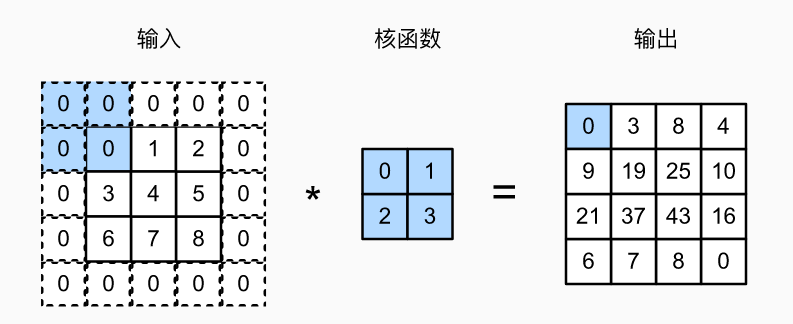

- 我们将3x3输入填充到5x5，那么它的输出就增加为4x4。阴影部分是第一个输出元素以及用于输出计算的输入和核张量元素:$0*0+0*1+0*2+0*3=0$


通常，如果我们添加$p_h$行填充（大约一半在顶部，一半在底部）和$p_w$列填充（左侧大约一半，右侧一半），则输出形状将为
   $$(n_h-k_h+p_h+1)*(n_w-k_w+p_w+1)$$

这意味着输出的高度和宽度将分别增加$p_h$和$p_w$。

在许多情况下，我们需要设置$p_h=k_h-1$和$p_w=k_w-1$，使输入和输出具有相同的高度和宽度。 这样可以在构建网络时更容易地预测每个图层的输出形状。假设是奇数，我们将在高度的两侧填充$p_h/2$行。 如果是偶数，则一种可能性是在输入顶部填充$p_h/2$行，在底部填充$p_h/2$行。同理，我们填充宽度的两侧。

卷积神经网络中卷积核的高度和宽度通常为奇数，例如1、3、5或7。 选择奇数的好处是，保持空间维度的同时，我们可以在顶部和底部填充相同数量的行，在左侧和右侧填充相同数量的列。

此外，使用奇数的核大小和填充大小也提供了书写上的便利。对于任何二维张量X，当满足： 
1. 卷积核的大小是奇数；
2. 所有边的填充行数和列数相同； 
3. 输出与输入具有相同高度和宽度 

则可以得出：输出Y[i, j]是通过以输入X[i, j]为中心，与卷积核进行互相关计算得到的。

In [10]:
#我们创建一个高度和宽度为3的二维卷积层，并在所有侧边填充1个像素。给定高度和宽度为8的输入，则输出的高度和宽度也是8

import torch
from torch import nn


# 为了方便起见，我们定义了一个计算卷积层的函数。
# 此函数初始化卷积层权重，并对输入和输出提高和缩减相应的维数
def comp_conv2d(conv2d, X):
    # 这里的（1，1）表示批量大小和通道数都是1
    X = X.reshape((1, 1) + X.shape)
    Y = conv2d(X)
    # 省略前两个维度：批量大小和通道
    return Y.reshape(Y.shape[2:])

# 请注意，这里每边都填充了1行或1列，因此总共添加了2行或2列
conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1)
X = torch.rand(size=(8, 8))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

- 当卷积核的高度和宽度不同时，我们可以填充不同的高度和宽度，使输出和输入具有相同的高度和宽度。在如下示例中，我们使用高度为5，宽度为3的卷积核，高度和宽度两边的填充分别为2和1。

In [11]:
conv2d = nn.Conv2d(1, 1, kernel_size=(5, 3), padding=(2, 1))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

In [12]:
comp_conv2d(conv2d, X)

tensor([[ 0.3643, -0.0338,  0.0138,  0.2956, -0.0110,  0.1435, -0.2436,  0.1626],
        [ 0.2254,  0.0941, -0.0026, -0.0067,  0.4215, -0.0238, -0.0252,  0.0425],
        [ 0.1983,  0.0434,  0.3209,  0.1814, -0.0918,  0.2153, -0.0633,  0.2475],
        [ 0.4003, -0.0006, -0.2142,  0.5196, -0.1269,  0.0154, -0.0652,  0.4282],
        [ 0.4910,  0.0229,  0.0910, -0.0939,  0.2671, -0.0055,  0.3222, -0.0591],
        [ 0.0279,  0.0533,  0.3464,  0.1819,  0.0705,  0.0215,  0.2431,  0.0473],
        [ 0.2698,  0.1183,  0.4205,  0.1861,  0.2063,  0.1383,  0.0953,  0.0796],
        [ 0.2267,  0.2210, -0.1438, -0.0254,  0.1535,  0.2578,  0.1766, -0.1586]],
       grad_fn=<ViewBackward>)

## 步幅

在计算互相关时，卷积窗口从输入张量的左上角开始，向下、向右滑动。 在前面的例子中，我们默认每次滑动一个元素。 但是，有时候为了高效计算或是缩减采样次数，卷积窗口可以跳过中间位置，每次滑动多个元素。

步幅定义：我们将每次滑动元素的数量称为步幅（stride）。

我们只使用过高度或宽度为的步幅，那么如何使用较大的步幅呢？ 

- 符号定义：输入: $n_h*n_w$ ，卷积核: $k_h*k_w$  h:高度(height) w:宽度(width)

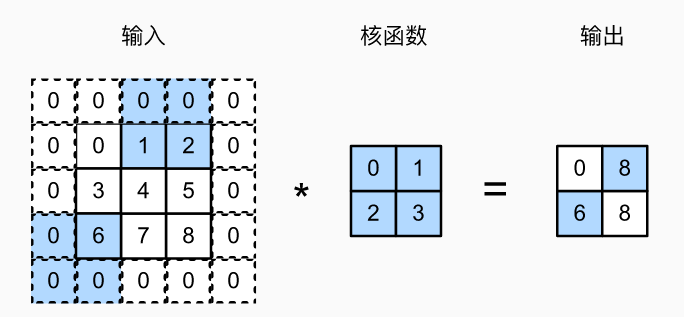

垂直步幅为3，水平步幅为2的二维互相关运算。 着色部分是输出元素以及用于输出计算的输入和内核张量元素：

0x0+0x1+1x2+2x3=8  

0x0+6x1+0x2+0x3=6

可以看到，为了计算输出中第一列的第二个元素和第一行的第二个元素，卷积窗口分别向下滑动三行和向右滑动两列。但是，当卷积窗口继续向右滑动两列时，没有输出，因为输入元素无法填充窗口（除非我们添加另一列填充）

通常，当垂直步幅为$p_h=k_h-1$、水平步幅为$p_w=k_w-1$时，输出形状为$$[(n_h-k_w+p_h+s_h)/s_h]*[(n_h-k_w+p_h+s_h)/s_w)]$$


如果我们设置了$p_h=k_h-1$和$p_w=k_w-1$，则输出形状将简化为$[(n_h+s_h-1)/s_h]*[(n_h+s_w-1)/s_w)]$。 更进一步，如果输入的高度和宽度可以被垂直和水平步幅整除，则输出形状将为$(n_h/s_h)*(n_w/s_w)$

In [13]:
# 我们将高度和宽度的步幅设置为2，从而将输入的高度和宽度减半
conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1, stride=2)
comp_conv2d(conv2d, X).shape

torch.Size([4, 4])

## 特征映射与感受野

输出的卷积层有时被称为特征映射（feature map），因为它可以被视为一个输入映射到下一层的空间维度的转换器。 在卷积神经网络中，对于某一层的任意元素，其感受野（receptive field）是指在前向传播期间可能影响计算的所有元素（来自所有先前层）。

感受野（Receptive Field），指的是神经网络中神经元“看到的”输入区域，在卷积神经网络中，feature map上某个元素的计算受输入图像上某个区域的影响，这个区域即该元素的感受野

卷积神经网络中，越深层的神经元看到的区域越大，如下图所示，卷积核的大小均为3x3，步幅均为1，绿色标记的是Layer2每个神经元看到的区域，黄色标记的是Layer3看到的区域，具体地，Layer2每个神经元可以看到Layer1上3x3大小的区域，Layer3每个神经元看到Layer2上3x3大小的区域，该区域又可以看到Layer1上5x5大小的区域

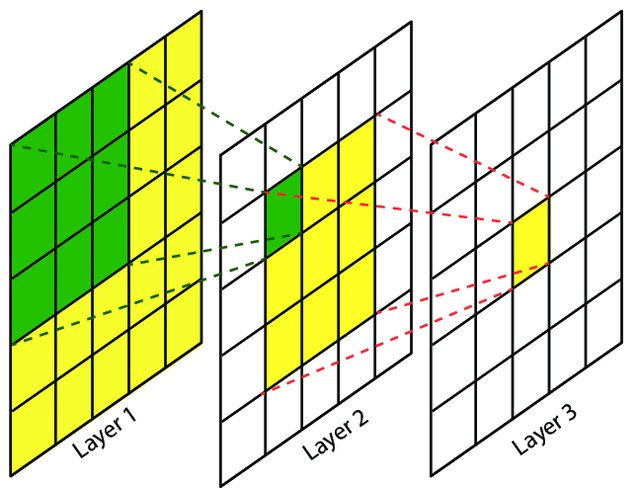

所以，感受野是个相对概念，某层feature map上的元素看到前面不同层上的区域范围是不同的，通常在不特殊指定的情况下，感受野指的是看到输入图像上的区域

请注意，感受野可能大于输入的实际大小，因为卷积运算时必需保证输入核卷积核的大小是一样的，白色虚线为填充

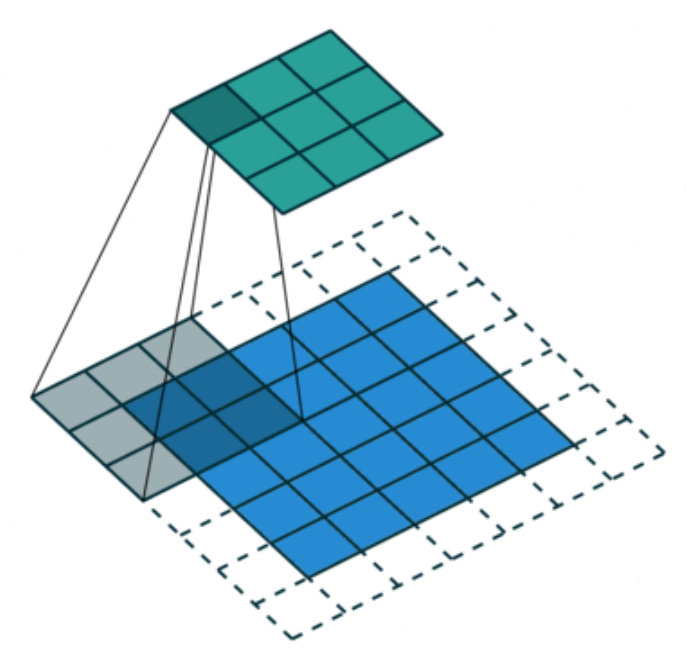

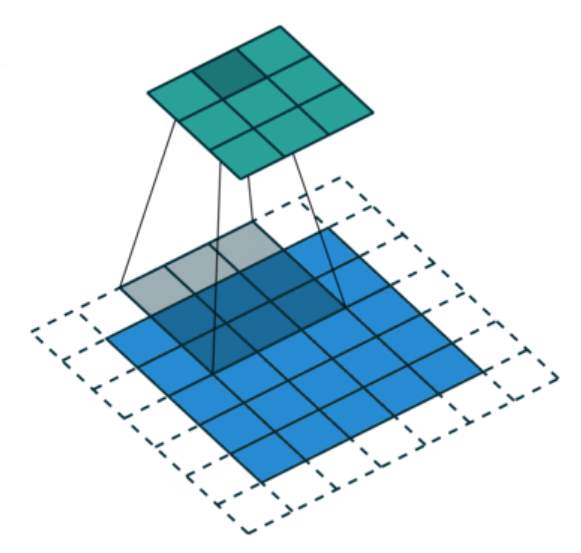

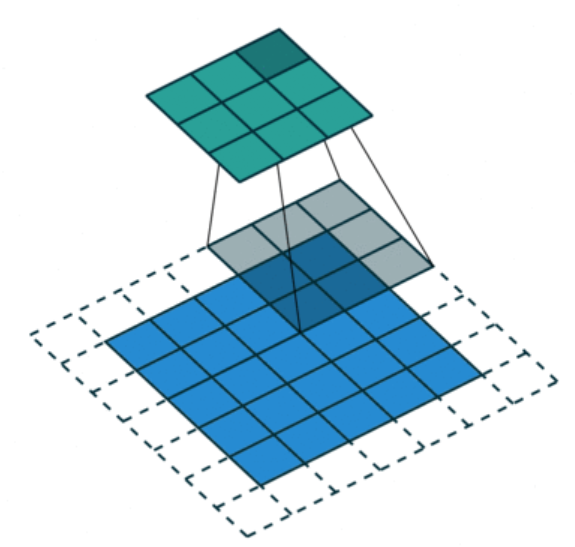

- 多层卷积网络的感受野,三个参数: 卷积核大小(kernel size) ,填充(padding), 步幅(stride)

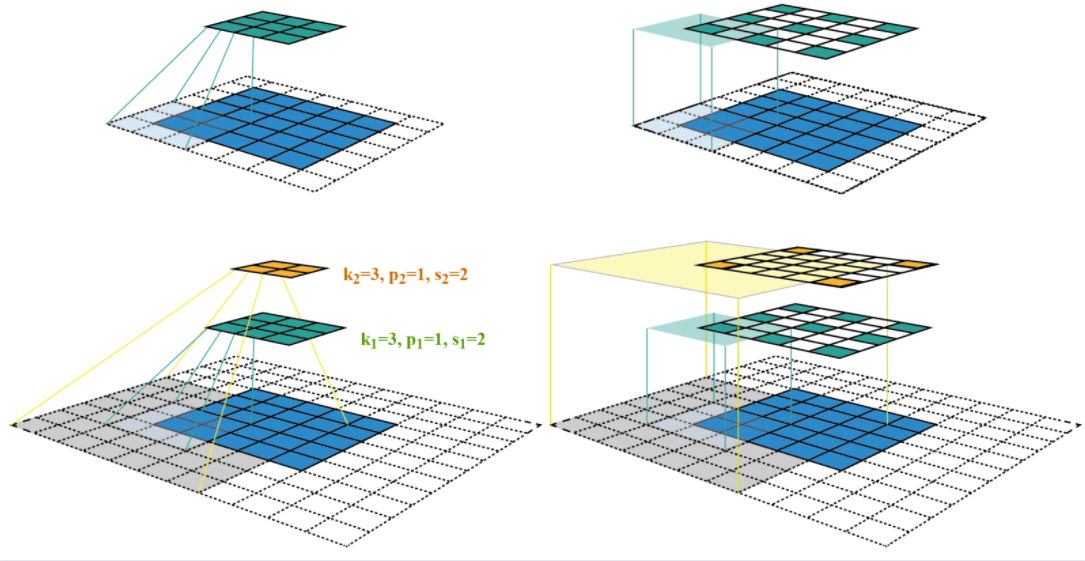


为了简洁起见，当输入高度和宽度两侧的填充数量分别为$p_h$和$p_w$时，我们称之为填充$(p_h,p_w)$。当$p_h=p_w-p$时，填充是$p$。同理，当高度和宽度上的步幅分别为$s_h$和$s_w$时，我们称之为步幅。特别地，当$s_h=s_w=s$时，我们称步幅为$s$。默认情况下，填充为0，步幅为1。在实践中，我们很少使用不一致的步幅或填充，也就是说，我们通常有$p_h=p_w$和$s_h=s_w$。


- 填充可以增加输出的高度和宽度。这常用来使输出与输入具有相同的高和宽。

- 步幅可以减小输出的高和宽，例如输出的高和宽仅为输入的高和宽的（是一个大于的整数）。

- 填充和步幅可用于有效地调整数据的维度

## 多输出多输入通道

每个图像都经过多个通道和多层卷积层，例如彩色图像具有标准的RGB通道来代表红、绿和蓝。 上面都是单个输入和单个输出通道的简化例子。 其实我们可以将输入、卷积核和输出看作二维张量。

当我们添加通道时，我们的输入和隐藏的表示都变成了三维张量。例如，每个RGB输入图像具有的形状。我们将这个大小为$3*h*w$的轴称为通道（channel）维度。下面，我们将更深入地研究具有多输入和多输出通道的卷积核

### 多输入通道

当输入包含多个通道时，需要构造一个与输入数据具有相同输入通道数的卷积核，以便与输入数据进行互相关运算。假设输入的通道数为$c_i$，那么卷积核的输入通道数也需要为$c_i$。如果卷积核的窗口形状是$k_h*k_w$，那么当时$c_i=1$，我们可以把卷积核看作形状为$k_h*k_w$的二维张量

然而，当$c_i>1$时，我们卷积核的每个输入通道将包含形状为$k_h*k_w$的张量。将这些张量$c_i$连结在一起可以得到形状为$c_i*k_h*k_w$的卷积核。由于输入和卷积核都有$c_i$个通道，我们可以对每个通道输入的二维张量和卷积核的二维张量进行互相关运算，再对通道求和（将$c_i$的结果相加）得到二维张量。这是多通道输入和多输入通道卷积核之间进行二维互相关运算的结果。

多输入运算步骤：
1. 每个通道的输入与对应通道的卷积核进行互相关运算
2. 最后对各通道的运算结果进行求和

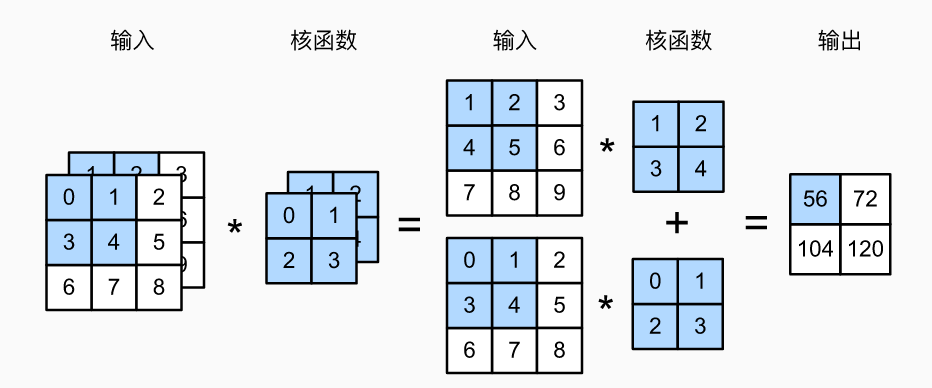

In [14]:
def corr2d_multi_in(X, K):
    # 先遍历“X”和“K”的第0个维度（通道维度），再把它们加在一起
    return sum(corr2d(x, k) for x, k in zip(X, K))

X = torch.tensor([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
               [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]])
K = torch.tensor([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])

corr2d_multi_in(X, K)

tensor([[ 56.,  72.],
        [104., 120.]])

### 多输出通道
每一层有多个输出通道是至关重要的。在最流行的神经网络架构中，随着神经网络层数的加深，我们常会增加输出通道的维数，通过减少空间分辨率以获得更大的通道深度。

**直观地说，我们可以将每个通道看作是对不同特征的响应。**而现实可能更为复杂一些，因为每个通道不是独立学习的，而是为了共同使用而优化的。

- 因此，多输出通道并不仅是学习多个单通道的检测器。

用$c_i$和$c_0$分别表示输入和输出通道的数目，并让$k_h$和$k_w$为卷积核的高度和宽度。为了获得多个通道的输出，我们可以为每个输出通道创建一个形状为的卷积核张量$c_i*k_h*k_w$，这样卷积核的形状是$c_0*c_i*k_h*k_w$。

在互相关运算中，每个输出通道先获取所有输入通道，再以对应该输出通道的卷积核计算出结果。

In [15]:
def corr2d_multi_in_out(X, K):
    # 迭代“K”的第0个维度，每次都对输入“X”执行互相关运算。
    # 最后将所有结果都叠加在一起
    return torch.stack([corr2d_multi_in(X, k) for k in K], 0)

# 通过将核张量K与K+1（K中每个元素加）和K+2连接起来，构造了一个具有3个输出通道的卷积核。
K = torch.stack((K, K + 1, K + 2), 0)
K.shape

torch.Size([3, 2, 2, 2])

In [16]:
#我们对输入张量X与卷积核张量K执行互相关运算。现在的输出包含个通道，第一个通道的结果与先前输入张量X和多输入单输出通道的结果一致。
corr2d_multi_in_out(X, K)

tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])

## 1x1卷积层
1x1卷积看起来似乎没有多大意义。 毕竟，卷积的本质是有效提取相邻像素间的相关特征，而卷积显然没有此作用。 尽管如此，1x1卷积仍然十分流行，经常包含在复杂深层网络的设计中。

因为使用了最小窗口，1x1卷积失去了卷积层的特有能力——在高度和宽度维度上，识别相邻元素间相互作用的能力。 其实卷积的唯一计算发生在通道上。

1x1卷积特点：

1. 当以每像素为基础应用时，1x1卷积层相当于全连接层。

2. 1x1卷积层通常用于调整网络层的通道数量和控制模型复杂性


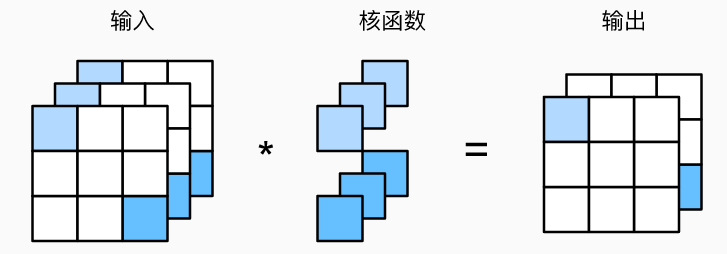

- 计算使用了具有3个输入通道和2个输出通道的1x1卷积核
这里输入和输出具有相同的高度和宽度，输出中的每个元素都是从输入图像中同一位置的元素的线性组合。 我们可以将1x1卷积层看作是在每个像素位置应用的全连接层，以$c_0$个输入值转换为$c_i$个输出值。 因为这仍然是一个卷积层，所以跨像素的权重是一致的。 同时，卷积层需要的权重维度为$c_0*c_i$，再额外加上一个偏置。



In [17]:
def corr2d_multi_in_out_1x1(X, K):
    """
    全连接层实现卷积,结果和corr2d_multi_in_out相同
    """
    c_i, h, w = X.shape
    c_o = K.shape[0]
    X = X.reshape((c_i, h * w))
    K = K.reshape((c_o, c_i))
    # 全连接层中的矩阵乘法
    Y = torch.matmul(K, X)
    return Y.reshape((c_o, h, w))

X = torch.normal(0, 1, (3, 3, 3))
K = torch.normal(0, 1, (2, 3, 1, 1))

Y1 = corr2d_multi_in_out_1x1(X, K)
Y2 = corr2d_multi_in_out(X, K)
assert float(torch.abs(Y1 - Y2).sum()) < 1e-6

In [20]:
Y1,Y2

(tensor([[[ 2.0350,  0.8884, -2.2373],
          [-1.4222, -1.4649, -0.9528],
          [ 1.6003,  3.8750, -1.3670]],
 
         [[ 0.4500, -0.2435, -0.5975],
          [-1.1386,  0.8322,  0.0210],
          [-0.2981,  0.0425,  0.3866]]]), tensor([[[ 2.0350,  0.8884, -2.2373],
          [-1.4222, -1.4649, -0.9528],
          [ 1.6003,  3.8750, -1.3670]],
 
         [[ 0.4500, -0.2435, -0.5975],
          [-1.1386,  0.8322,  0.0210],
          [-0.2981,  0.0425,  0.3866]]]))

## 池化

与卷积层类似，池化层运算符由一个固定形状的窗口组成，该窗口根据其步幅大小在输入的所有区域上滑动，为固定形状窗口（有时称为池化窗口）遍历的每个位置计算一个输出。 然而，不同于卷积层中的输入与卷积核之间的互相关计算，汇聚层不包含参数。 相反，池运算是确定性的，我们通常计算池化窗口中所有元素的最大值或平均值。这些操作分别称为最大池化层（maximum pooling）和平均池化层（average pooling）,池化层也称汇聚层。

在这两种情况下，与互相关运算符一样，汇聚窗口从输入张量的左上角开始，从左往右、从上往下的在输入张量内滑动。在汇聚窗口到达的每个位置，它计算该窗口中输入子张量的最大值或平均值。计算最大值或平均值是取决于使用了最大池化层还是平均池化层。

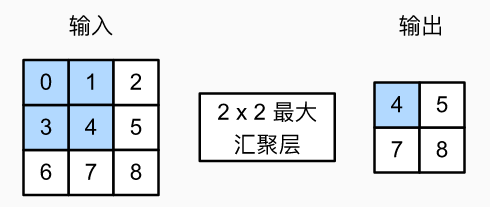

这四个元素为每个汇聚窗口中的最大值：
\begin{gather}
max(0,1,3,4)=4 \\
max(1,2,4,5)=5 \\
max(3,4,6,7)=7 \\
max(4,5,7,8)=8 
\end{gather}

回到上面的边缘检测的小示例，现在我们将使用卷积层的输出作为2x2最大汇聚的输入。 设置卷积层输入为X，汇聚层输出为Y。 无论X[i, j]和X[i, j + 1]的值相同与否，或X[i, j + 1]和X[i, j + 2]的值相同与否，汇聚层始终输出Y[i, j] = 1。 

* 也就是说，使用2x2最大池化层，即使在高度或宽度上移动一个元素，卷积层仍然可以识别到模式。

池化层的特点：
1. 汇聚层的主要优点之一是减轻卷积层对位置的过度敏感。

2. 我们可以指定汇聚层的填充和步幅。

3. 使用最大汇聚层以及大于1的步幅，可减少空间维度（如高度和宽度）。

4. 池化层的输出通道数与输入通道数相同

In [23]:
def pool2d(X, pool_size, mode='max'):
    p_h, p_w = pool_size
    Y = torch.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i, j] = X[i: i + p_h, j: j + p_w].max()
            elif mode == 'avg':
                Y[i, j] = X[i: i + p_h, j: j + p_w].mean()
    return Y

In [24]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
pool2d(X, (2, 2),mode='max')

tensor([[4., 5.],
        [7., 8.]])

In [25]:
pool2d(X, (2, 2),mode='avg')

tensor([[2., 3.],
        [5., 6.]])

- 与卷积层一样，汇聚层也可以改变输出形状
- 可以通过填充和步幅以获得所需的输出形状

In [27]:
# 构造了一个输入张量X，它有四个维度，其中样本数和通道数都是1。
X = torch.arange(16, dtype=torch.float32).reshape((1, 1, 4, 4))
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

默认情况下，深度学习框架中的步幅与汇聚窗口的大小相同。 因此，如果我们使用形状为(3, 3)的汇聚窗口，那么默认情况下，我们得到的步幅形状为(3, 3)。

1. 当然，填充和步幅可以手动设定。
2. 不仅如此，我们可以设定一个任意大小的矩形池化窗口，并分别设定填充和步幅的高度和宽度。
3. 在处理多通道输入数据时，池化层在每个输入通道上单独运算，而不是像卷积层一样在通道上对输入进行汇总。 这意味着池化层的输出通道数与输入通道数相同。

In [28]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

In [ ]:
pool2d = nn.MaxPool2d((2, 3), stride=(2, 3), padding=(0, 1))
pool2d(X)

In [ ]:
# 下面，我们将在通道维度上连结张量X和X + 1，以构建具有2个通道的输入。
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

### 卷积的个人理解

卷积的本质是有效提取相邻像素间的相关特征，所以卷积操作看成是提取特征的方式，卷积核神经元就是图像处理中的滤波器，卷积层的每个滤波器都会有自己所关注一个图像特征，比如垂直边缘，水平边缘，颜色，纹理等等，这些所有神经元加起来就好比就是整张图像的特征提取器集合。这种提取特征方式与位置无关（就如why-conv里说的平移不变性：不管检测对象出现在图像中的哪个位置，神经网络的前面几层应该对相同的图像区域具有相似的反应，即为“平移不变性”）。

个人理解这种不变性是基于物理实际的，即相同的特征模式对应于一种物理实际，比如物体间的边缘界面理论上是可以通过空间图像的差异区分（体现在图像颜色上就是色差值和色差梯度等这些指标，当然前提是图像有足够高的锐度），那么这种提取后的特征也应该适用于图像的其它部分。所以对图像的各个输入，单个二维卷积张量，也就是文中的一个$K_h*k_w$矩阵是权值共享的，偏置项也是如此。

针对多通道操作的小理解：

可以理解成加权相加。是对多个上层输出通道识别出来的patten的一个聚合。只是这里的加权值是可以融合到卷积核里的。

## LeNet

LeNet（LeNet-5）由两个部分组成：

1. 卷积编码器：由两个卷积层组成;

2. 全连接层密集块：由三个全连接层组成。

每个卷积块中的基本单元是一个卷积层、一个sigmoid激活函数和平均汇聚层。请注意，虽然ReLU和最大汇聚层更有效，但它们在20世纪90年代还没有出现。每个卷积层使用5x5卷积核和一个sigmoid激活函数。这些层将输入映射到多个二维特征输出，通常同时增加通道的数量。第一卷积层有6个输出通道，而第二个卷积层有16个输出通道。每个2x2池操作（步幅2）通过空间下采样将维数减少4倍。卷积的输出形状由批量大小、通道数、高度、宽度决定。

为了将卷积块的输出传递给稠密块，我们必须在小批量中展平每个样本。换言之，我们将这个四维输入转换成全连接层所期望的二维输入。这里的二维表示的第一个维度索引小批量中的样本，第二个维度给出每个样本的平面向量表示。LeNet的稠密块有三个全连接层，分别有120、84和10个输出。因为我们在执行分类任务，所以输出层的10维对应于最后输出结果的数量。

# 简化版实现(去掉了最后一层的高斯激活)
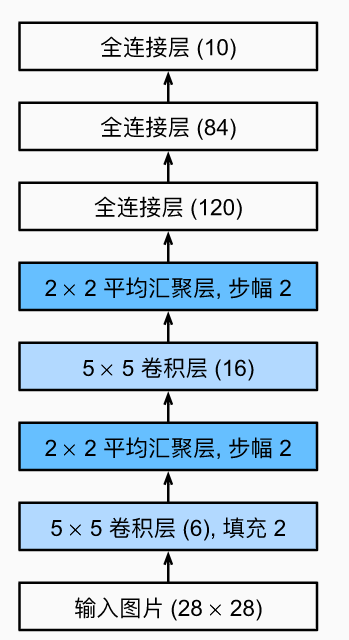

In [29]:

net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))

In [30]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])
